In [1]:
import matplotlib
import copy
import logging

from data.data_loader import Dataset

from misc.preferences import PREFERENCES
from misc.run_configuration import get_default_params, randomize_params, OutputLayerType, hyperOpt_goodParams, elmo_params
from misc import utils

from optimizer import get_optimizer
from criterion import NllLoss, LossCombiner

from models.transformer.encoder import TransformerEncoder
from models.jointAspectTagger import JointAspectTagger
from trainer.train import Trainer
import pprint
from data.germeval2017 import germeval2017_dataset


In [2]:
PREFERENCES.defaults(
    data_root='./data/germeval2017',
    data_train='train_v1.4.tsv',    
    data_validation='dev_v1.4.tsv',
    data_test='test_TIMESTAMP1.tsv',
    early_stopping='highest_5_F1'
)
def load(hp, logger):
    dataset = Dataset(
        'germeval',
        logger,
        hp,
        source_index=0,
        target_vocab_index=2,
        data_path=PREFERENCES.data_root,
        train_file=PREFERENCES.data_train,
        valid_file=PREFERENCES.data_validation,
        test_file=PREFERENCES.data_test,
        file_format='.tsv',
        init_token=None,
        eos_token=None
    )
    dataset.load_data(germeval2017_dataset, verbose=True)
    return dataset

In [3]:
def load_model(dataset, hp, experiment_name):
    loss = LossCombiner(4, dataset.class_weights, NllLoss)
    transformer = TransformerEncoder(dataset.source_embedding,
                                     hyperparameters=hp)
    model = JointAspectTagger(transformer, hp, 4, 20, dataset.target_names)
    optimizer = get_optimizer(model, hp)
    trainer = Trainer(
                        model,
                        loss,
                        optimizer,
                        hp,
                        dataset,
                        experiment_name,
                        enable_tensorboard=False,
                        verbose=True)
    return trainer

In [4]:
experiment_name = 'testing'
use_cuda = True

In [5]:
# get general logger just for search
experiment_name = utils.create_loggers(experiment_name=experiment_name)
logger = logging.getLogger(__name__)

Log path is  C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\logs\testing\2


In [6]:
utils.get_current_git_commit()
logger.info('Current commit: ' + utils.get_current_git_commit())

In [7]:
hp = get_default_params(use_cuda, hyperOpt_goodParams)
hp.num_epochs = 20
hp.log_every_xth_iteration = -1
hp.adam_weight_decay = 1e-5
hp.pointwise_layer_size = 300
hp.n_enc_blocks = 4

In [8]:
dataset_logger = logging.getLogger('data_loader')
    
logger.debug('Load dataset')
dataset = load(hp, dataset_logger)
logger.debug('dataset loaded')
logger.debug('Load model')
trainer = load_model(dataset, hp, experiment_name)
logger.debug('model loaded')

logger.debug('Begin training')
model = None

+-------------------------+
|  GERM EVAL 2017 DATASET |
+---------------+---------+
|     Split     |   Size  |
+---------------+---------+
|     train     |  17043  |
|   validation  |   2049  |
|      test     |   2095  |
+---------------+---------+
+--------------------------------------+
|           Vocabulary Stats           |
+------------------------------+-------+
|          Vocabulary          |  Size |
+------------------------------+-------+
|              id              | 21187 |
|           comments           | 68611 |
|      general_sentiments      |   3   |
|      aspect_sentiments       |   4   |
|           padding            | 23766 |
|          Allgemein           |   4   |
|          Atmosphäre          |   4   |
| Auslastung_und_Platzangebot  |   4   |
|       Barrierefreiheit       |   4   |
|         Connectivity         |   4   |
|      DB_App_und_Website      |   4   |
|            Design            |   4   |
|   Gastronomisches_Angebot    |   4   |
|         


pre_training - INFO - Classes: ['n/a', 'neutral', 'negative', 'positive']
pre_training - INFO - JointAspectTagger (
  (encoder): TransformerEncoder(
    (src_embeddings): Embedding(68611, 300)
    (positional_encoding): PositionalEncoding2(
      (dropout): Dropout(p=0.302424)
    )
    (encoder_blocks): ModuleList(
      (0): EncoderBlock(
        (self_attention_layer): MultiHeadedSelfAttentionLayer(
          (query_projections): Linear(in_features=300, out_features=300, bias=False)
          (key_projections): Linear(in_features=300, out_features=300, bias=False)
          (value_projections): Linear(in_features=300, out_features=300, bias=False)
          (attention_layer): ScaledDotProductAttentionLayer(
            (dropout): Dropout(p=0.302424)
          )
          (w_0): Linear(in_features=300, out_features=300, bias=False)
          (dropout): Dropout(p=0.302424)
        )
        (feed_forward_layer): PointWiseFCLayer(
          (w_1): Linear(in_features=300, out_features=

In [9]:
result = trainer.train(use_cuda=hp.use_cuda, perform_evaluation=False)
#trainer.load_model(custom_path='C:\\Users\\felix\\OneDrive\\Studium\\Studium\\6. Semester\\MA\\Project\\ABSA-Transformer\\logs\\test')


pre_training - DEBUG - train with cuda support
pre_training - INFO - 1421 Iterations per epoch with batch size of 12
pre_training - INFO - Total iterations: 28420
pre_training - INFO - Total number of samples: 341040
pre_training - INFO - START training.


A Jupyter Widget

# EP	# IT	tr loss		val loss	f1		acc		duration / total time
1	17k	11.21		9.48		0.244		0.959		4.98m - 5.0m / 0.0m
2	34k	10.26		10.03		0.244		0.959		4.66m - 9.9m / 99.8m
3	51k	10.40		9.70		0.223		0.873		4.82m - 14.7m / 93.8m
4	68k	10.51		10.00		0.234		0.916		4.74m - 19.5m / 96.6m
5	85k	10.50		9.41		0.244		0.959		4.62m - 24.1m / 95.2m
6	102k	10.35		9.38		0.245		0.955		182.63m - 206.7m / 93.3m
7	119k	10.17		9.89		0.244		0.959		4.81m - 211.5m / 2763.5m
8	136k	9.97		9.48		0.245		0.955		4.88m - 216.4m / 274.0m
9	153k	9.94		9.66		0.234		0.916		4.70m - 221.1m / 275.0m
10	171k	9.93		9.42		0.234		0.916		4.57m - 225.7m / 272.8m
11	188k	9.88		9.14		0.244		0.959		20.73m - 246.4m / 271.4m


In [ ]:
trainer.get_df()

In [ ]:
# perform evaluation and log results
result = trainer.perform_final_evaluation(use_test_set=True, verbose=False)

In [ ]:
trainer.get_df()

In [ ]:
trainer.get_df()

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict

%matplotlib inline

sns.__version__


'0.9.0'

In [52]:

df_row = {
    'epoch': int(0),
    'sample iteration': int(0),
    'metric type': '',				# loss, f1, etc.
    'iterator type': '',			# train, valid, test
    'value': float(0.0),			# value of the metric
    'is general': False,			# is the metric a general metric or an head-metric
    'head name': '',				# name of the transformer head
    'head category': ''				# category of the transformer head (n/a, neutral, etc)
}
d_dict = defaultdict(**df_row)
print(d_dict['epoch'])

0


In [38]:
df = pd.read_pickle("C:\\Users\\felix\\OneDrive\\Studium\\Studium\\6. Semester\\MA\\Project\\ABSA-Transformer\\logs\\testing\\df.pkl")
#df.set_index('iteration', inplace=True)
df

,epoch,head category,head name,is general,iteration,iterator type,metric type,value
0,0.0,,Allgemein,0.0,12000.0,validation,f1,0.185157
1,0.0,n/a,Allgemein,0.0,12000.0,validation,f1,0.000000
2,0.0,n/a,Allgemein,0.0,12000.0,validation,precission,0.000000
3,0.0,n/a,Allgemein,0.0,12000.0,validation,recall,0.000000
4,0.0,neutral,Allgemein,0.0,12000.0,validation,f1,0.740627
5,0.0,neutral,Allgemein,0.0,12000.0,validation,precission,1.000000
6,0.0,neutral,Allgemein,0.0,12000.0,validation,recall,0.588092
7,0.0,negative,Allgemein,0.0,12000.0,validation,f1,0.000000
8,0.0,negative,Allgemein,0.0,12000.0,validation,precission,0.000000
9,0.0,negative,Allgemein,0.0,12000.0,validation,recall,0.000000


In [39]:
loss_values = (df['metric type']=='loss')&(df['is general'] == 1.0)
f1_values = (df['metric type']=='f1')&(df['is general'] == 1.0)

# aspects mean f1 scores
head_scores = (df['metric type']=='f1')&(df['is general'] == 0.0)&(df['head category'] == '')
df[head_scores]

,epoch,head category,head name,is general,iteration,iterator type,metric type,value
0,0.0,,Allgemein,0.0,12000.0,validation,f1,0.185157
15,0.0,,Atmosphäre,0.0,12000.0,validation,f1,0.241223
30,0.0,,Auslastung_und_Platzangebot,0.0,12000.0,validation,f1,0.247970
45,0.0,,Barrierefreiheit,0.0,12000.0,validation,f1,0.248959
60,0.0,,Connectivity,0.0,12000.0,validation,f1,0.248589
75,0.0,,DB_App_und_Website,0.0,12000.0,validation,f1,0.248589
90,0.0,,Design,0.0,12000.0,validation,f1,0.249756
105,0.0,,Gastronomisches_Angebot,0.0,12000.0,validation,f1,0.249756
120,0.0,,Gepäck,0.0,12000.0,validation,f1,0.249817
135,0.0,,Image,0.0,12000.0,validation,f1,0.249572


In [26]:
sns.set(style="whitegrid")
sns.set_color_codes()
sns.set_context("paper")
sns.set(rc={"font.size":14,"axes.labelsize":18})
#fmri = sns.load_dataset("fmri")
#fmri


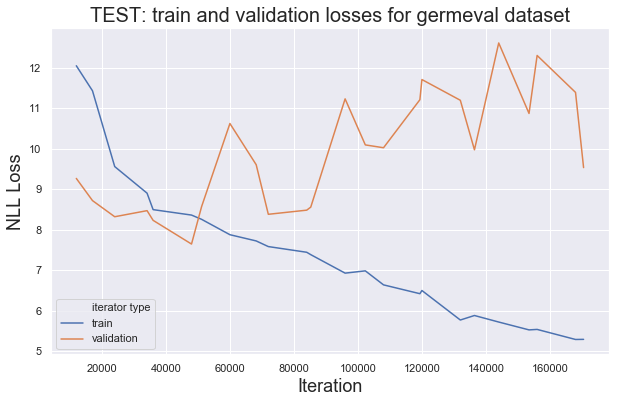

In [40]:
def generate_loss_curves(df, loss_name, experiment_name, dataset_name, max_epochs=None):

    plt.figure(figsize=(10,6))       
   
    
    ax = sns.lineplot(x='iteration', y='value', hue='iterator type', data=df[loss_values])
    plt.title(f"{experiment_name}: train and validation losses for {dataset_name} dataset", fontsize=20) 
    plt.ylabel(loss_name)
    plt.xlabel("Iteration") 
    if max_epochs is not None:
        plt.xlim((0, max_epochs))

generate_loss_curves(df, 'NLL Loss', 'TEST', 'germeval')

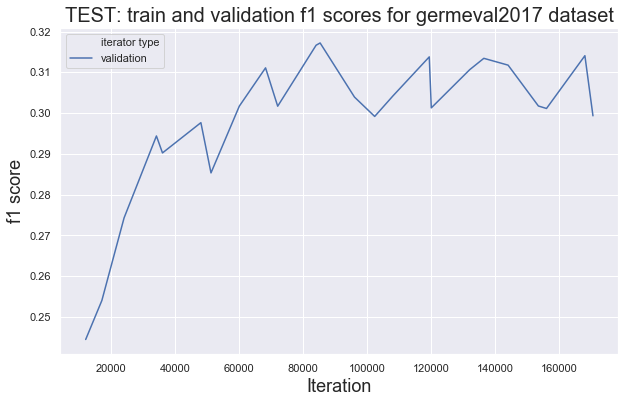

In [41]:
def generate_f1_curves(df, experiment_name, dataset_name, max_epochs=None):

    plt.figure(figsize=(10,6))       
   
    
    ax = sns.lineplot(x='iteration', y='value', hue='iterator type', data=df[f1_values])
    plt.title(f"{experiment_name}: train and validation f1 scores for {dataset_name} dataset", fontsize=20) 
    plt.ylabel('f1 score')
    plt.xlabel("Iteration") 
    if max_epochs is not None:
        plt.xlim((0, max_epochs))

generate_f1_curves(df, 'TEST', 'germeval2017')

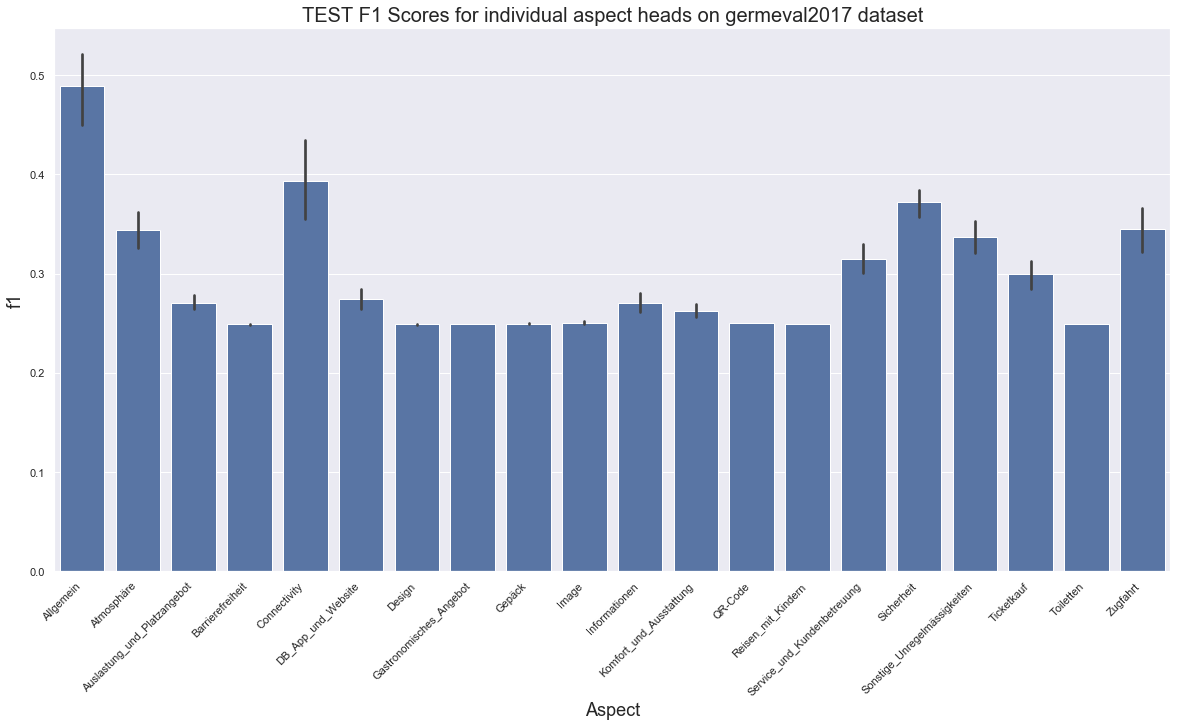

In [42]:
def plot_head_scores(df, experiment_name, dataset_name):
    plt.figure(figsize=(20,10))

    g = sns.barplot(data=df[head_scores], color='b', x='head name', y='value')
    plt.title(f"{experiment_name} F1 Scores for individual aspect heads on {dataset_name} dataset", fontsize=20) 
    plt.ylabel("f1")
    plt.xlabel("Aspect") 
    
    # fix rotation
    #fig_labels = [l.replace("f1", "") for l in transfromer_heads_f1_mean]
    #xtickNames = plt.setp(g, xticklabels=fig_labels)
    #plt.setp(xtickNames, rotation=45, fontsize=12)
    #g.set_xticklabels(xtickNames, rotation=45, ha="right", fontsize=12)
    plt.xticks(rotation=45, ha="right")
plot_head_scores(df, 'TEST', 'germeval2017')

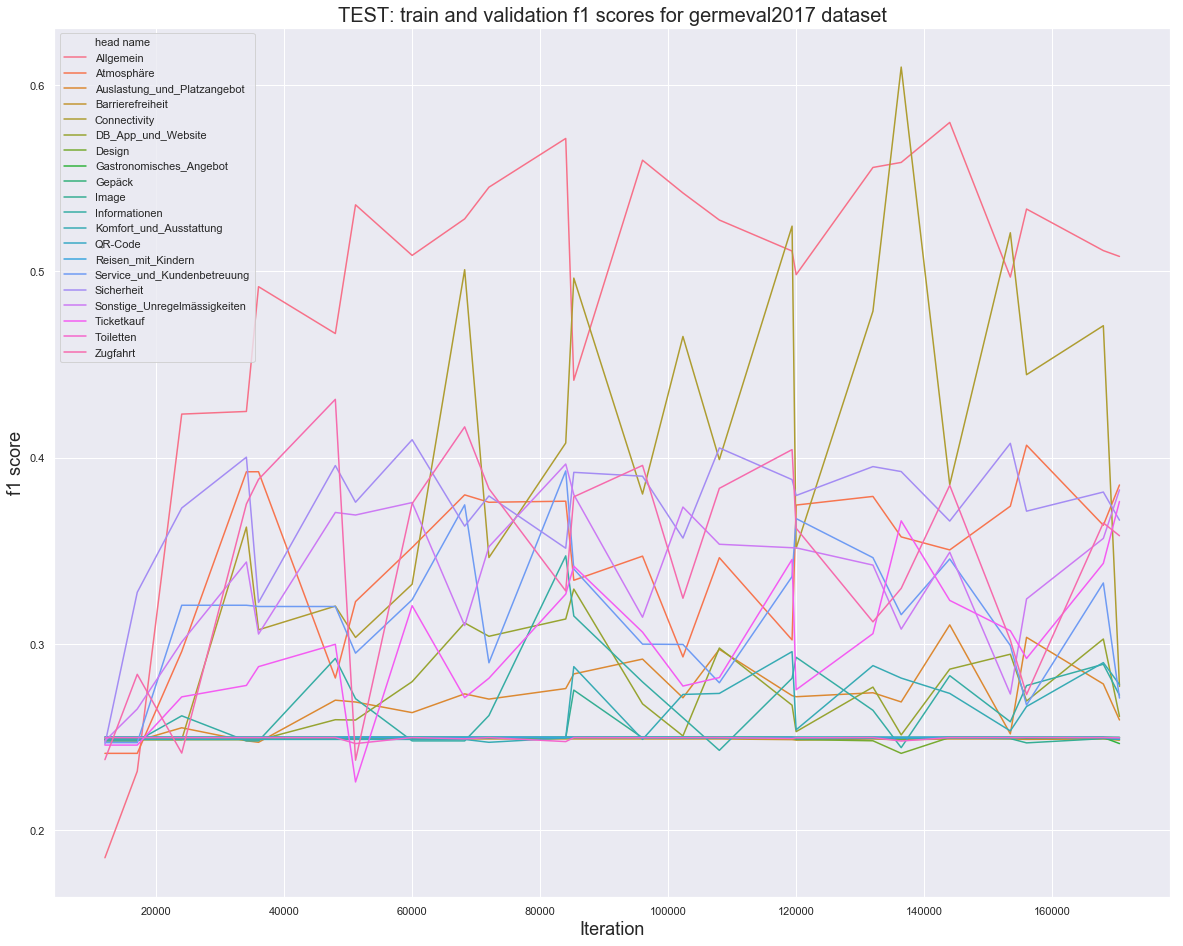

In [44]:
def generate_head_f1_curves(df, experiment_name, dataset_name, max_epochs=None):
    plt.figure(figsize=(20,16))
    
    ax = sns.lineplot(x='iteration', y='value', hue='head name', data=df[head_scores])
    plt.title(f"{experiment_name}: train and validation f1 scores for {dataset_name} dataset", fontsize=20) 
    plt.ylabel('f1 score')
    plt.xlabel("Iteration") 
    if max_epochs is not None:
        plt.xlim((0, max_epochs))
        
generate_head_f1_curves(df, 'TEST', 'germeval2017')

In [82]:
def make_df_cols_nice_again(cols):
    cols = [c.replace("_", " ") for c in cols]
    cols = [c.replace("t head", "") for c in cols]
    cols = [c.replace("validation", "") for c in cols]

    return cols

def make_df_nice_again(df):
    df.columns = [c.replace("_", " ") for c in df.columns]
    df.columns = [c.replace("t head", "") for c in df.columns]
    df.columns = [c.replace("validation", "") for c in df.columns]
    return df
    
def get_t_head_cols(df):
    transfromer_heads_f1_mean = [ct for i, ct in enumerate(df.columns.values) if ct.startswith('t_head_') and ct.endswith('_validation_f1') and not (ct.endswith('n/a_validation_f1') or ct.endswith('negative_validation_f1') or ct.endswith('positive_validation_f1') or ct.endswith('neutral_validation_f1'))]
    return transfromer_heads_f1_mean

def plot_head_f1(df, experiment_name, dataset_name):
    
    df = df.copy(deep=False)
    
    transfromer_heads_f1_mean = get_t_head_cols(df)
    transfromer_heads_f1_mean = make_df_cols_nice_again(transfromer_heads_f1_mean)
    df = make_df_nice_again(df)
    
    
    #df[transfromer_heads_f1_mean].index
    plt.figure(figsize=(20,10))
    sns.set(style="whitegrid")
    sns.set_color_codes()
    sns.set_context("paper")
    sns.set(rc={"font.size":14,"axes.labelsize":18})

    g = sns.barplot(data=df[transfromer_heads_f1_mean].tail(1), color="b")
    plt.title(f"{experiment_name} F1 Scores for individual aspect heads on {dataset_name} dataset", fontsize=20) 
    plt.ylabel("f1")
    plt.xlabel("Aspect") 
    #plt.xticks(rotation=45)

    fig_labels = [l.replace("f1", "") for l in transfromer_heads_f1_mean]
    xtickNames = plt.setp(g, xticklabels=fig_labels)
    #plt.setp(xtickNames, rotation=45, fontsize=12)
    g.set_xticklabels(xtickNames, rotation=45, ha="right", fontsize=12)


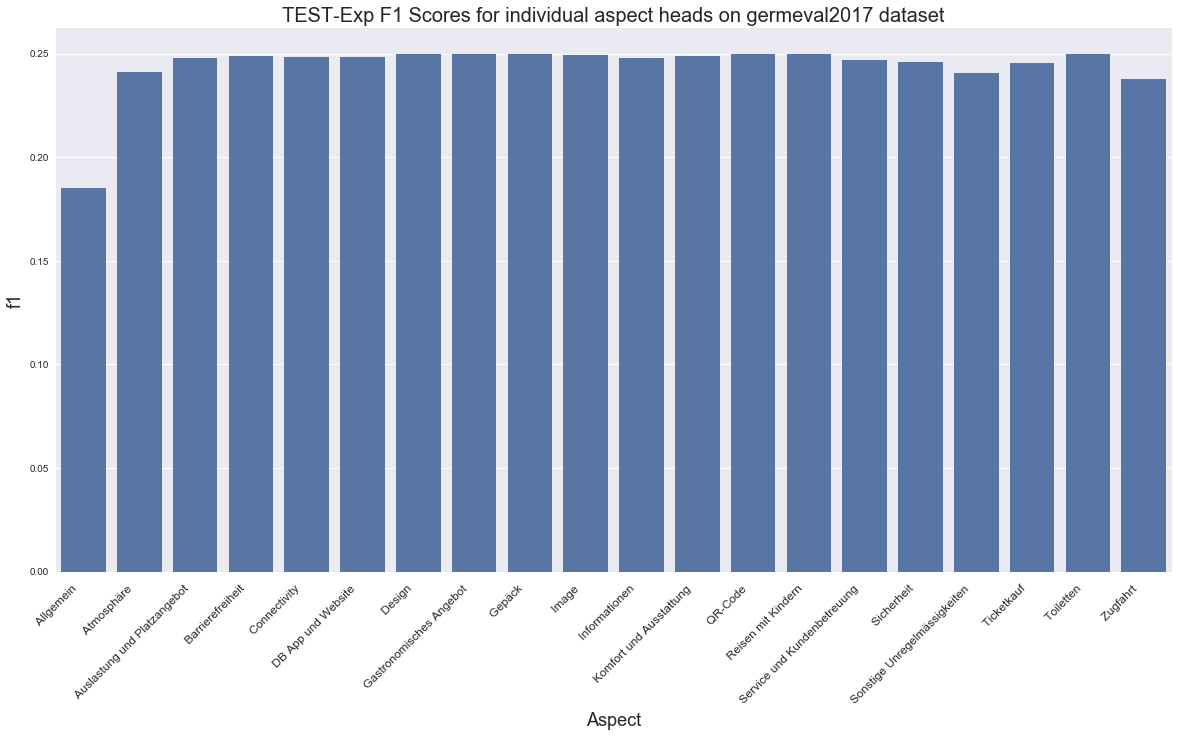

In [83]:
plot_head_f1(df, "TEST-Exp", "germeval2017")